### В этом проекте мы работаем с реляционными базами данных в сфере ритейла, где обрабатываю большие объемы данных, включая информацию о товарах, клиентах и продажах. 
### Использую SQL для написания сложных запросов и оптимизации производительности.

### Цель проекта:
#### Проект направлен на анализ данных о заказах с целью определения среднего количества товаров в заказах и количества уникальных заказов по странам доставки. Полученные результаты помогут понять региональные различия в покупательских предпочтениях и активности клиентов, а также выявить возможности для улучшения бизнес-процессов, таких как маркетинговые стратегии и логистика.

In [3]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [4]:
conn = psycopg2.connect(
    host = "127.0.0.1",
    port= 5433,
    database = "postgres",
    user = "postgres",
    password = "1234")

In [5]:
cursor = conn.cursor()

Устанавливаем подключение к базе данных PostgreSQL с указанием хоста, порта, имени базы данных и учетных данных. Создаем курсор для выполнения SQL-запросов

### Берем нужные нам данные с базы данных


In [8]:
# Выполненяем SQL-запроса для получения данных о заказах и товарах
cursor.execute("""
select
    o.order_id,
    pr.product_name,
    pr.product_id,
    o.customer_id,
    o.employee_id,
    o.order_date,
    o.shipped_date,
    o.ship_city,
    o.ship_country,
    od.quantity
from orders o
left join order_details od on o.order_id = od.order_id
left join products pr on od.product_id = pr.product_id""")


Выполняем SQL-запрос для объединения трех таблиц:
Используем LEFT JOIN, чтобы включить все заказы из orders, даже если отсутствуют соответствия в других таблицах.

In [10]:
data = cursor.fetchall()

In [11]:
data_pd = pd.DataFrame(data,
                       columns=['order_id', 'product_name', 'product_id', 'customer_id', 'employee_id', 'order_date', 'shipped_date', 'ship_city', 'ship_country', 'quantity'])
data_pd

,order_id,product_name,product_id,customer_id,employee_id,order_date,shipped_date,ship_city,ship_country,quantity
0,10248,Queso Cabrales,11,VINET,5,1996-07-04,1996-07-16,Reims,France,12
1,10248,Singaporean Hokkien Fried Mee,42,VINET,5,1996-07-04,1996-07-16,Reims,France,10
2,10248,Mozzarella di Giovanni,72,VINET,5,1996-07-04,1996-07-16,Reims,France,5
3,10249,Tofu,14,TOMSP,6,1996-07-05,1996-07-10,Münster,Germany,9
4,10249,Manjimup Dried Apples,51,TOMSP,6,1996-07-05,1996-07-10,Münster,Germany,40
...,...,...,...,...,...,...,...,...,...,...
2150,11077,Wimmers gute Semmelknödel,64,RATTC,1,1998-05-06,None,Albuquerque,USA,2
2151,11077,Louisiana Hot Spiced Okra,66,RATTC,1,1998-05-06,None,Albuquerque,USA,1
2152,11077,Röd Kaviar,73,RATTC,1,1998-05-06,None,Albuquerque,USA,2
2153,11077,Rhönbräu Klosterbier,75,RATTC,1,1998-05-06,None,Albuquerque,USA,4


Преобразуем результат запроса в DataFrame с использованием библиотеки pandas.
Назначаем имена столбцов для упрощения дальнейшего анализа данных.
Теперь таблица готова для работы с данными в Python.

#### Маркируем активные и неактивные заказы для удобства

In [14]:
def date_mark(row):
    if row['shipped_date'] == None:
        return 1
    else:
        return 0

In [15]:
data_pd['order_act_flag'] = data_pd.apply(date_mark, axis=1)
data_pd
#1 = активные (незаконченные заказы), 0 = неактивные заказы (законченные заказы)

,order_id,product_name,product_id,customer_id,employee_id,order_date,shipped_date,ship_city,ship_country,quantity,order_act_flag
0,10248,Queso Cabrales,11,VINET,5,1996-07-04,1996-07-16,Reims,France,12,0
1,10248,Singaporean Hokkien Fried Mee,42,VINET,5,1996-07-04,1996-07-16,Reims,France,10,0
2,10248,Mozzarella di Giovanni,72,VINET,5,1996-07-04,1996-07-16,Reims,France,5,0
3,10249,Tofu,14,TOMSP,6,1996-07-05,1996-07-10,Münster,Germany,9,0
4,10249,Manjimup Dried Apples,51,TOMSP,6,1996-07-05,1996-07-10,Münster,Germany,40,0
...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,Wimmers gute Semmelknödel,64,RATTC,1,1998-05-06,None,Albuquerque,USA,2,1
2151,11077,Louisiana Hot Spiced Okra,66,RATTC,1,1998-05-06,None,Albuquerque,USA,1,1
2152,11077,Röd Kaviar,73,RATTC,1,1998-05-06,None,Albuquerque,USA,2,1
2153,11077,Rhönbräu Klosterbier,75,RATTC,1,1998-05-06,None,Albuquerque,USA,4,1


Создали функцию которая позволит видеть, является ли заказ активным или не активным

### Исследуя уже отправленные заказы (неактивные), посчитаем количество заказов по странам.

In [18]:
finished_orders = data_pd[data_pd['order_act_flag'] == 0]

country_finished_order_counts_df = finished_orders.groupby('ship_country').agg({'order_id': 'nunique'}).reset_index().sort_values(by='order_id', ascending=False)

country_finished_order_counts_df

,ship_country,order_id
8,Germany,120
19,USA,119
3,Brazil,81
7,France,75
18,UK,56
20,Venezuela,43
1,Austria,38
16,Sweden,37
4,Canada,29
11,Mexico,27


Судя по информации из таблицы Германия лидирует с 120 уникальными заказами что делает её ключевым рынком среди представленных стран С занимает вторую позицию с 119 заказами демонстрируя схожий уровень активности Бразилия с 81 заказом и Франция с 75 заказами также показывают значительный вклад в общее количество завершенных заказов.

### Выводим каждую страну и считаем по ней среднее количество продуктов и количество заказов. (При этом учитываем репрезентативность результата)

In [21]:
# Выполнение SQL-запроса для получения данных о количество заказов и среднем количество товаров


cursor.execute("""
select o.ship_country, ROUND(AVG(od.quantity), 0) as avg_quantity, COUNT(DISTINCT o.order_id) AS avg_order_count

from orders o
left join order_details od ON o.order_id = od.order_id
group by o.ship_country

order by avg_quantity desc, avg_order_count desc;

""")

In [22]:
countries_avg_products_orders = cursor.fetchall()

In [23]:
countries_avg_products_orders_pd = pd.DataFrame(countries_avg_products_orders,
                       columns=['ship_country', 'avg_quantity', 'avg_order_count'])
countries_avg_products_orders_pd

,ship_country,avg_quantity,avg_order_count
0,Austria,41,40
1,Ireland,31,19
2,Germany,28,122
3,USA,27,122
4,Canada,26,30
5,Venezuela,25,46
6,Belgium,25,19
7,Switzerland,25,18
8,Denmark,25,18
9,Sweden,23,37


Австрия и Ирландия лидируют по среднему количеству продуктов на заказ, а Германия и США — по числу заказов (122). Венесуэла, Канада, Бельгия и Швейцария имеют схожие показатели в среднем около 25-26 продуктов.

### Исследуя уже отправленные заказы, можем посчитайть сумму выручки по странам.

In [26]:
cursor.execute("""
select o.ship_country, ROUND(SUM(od.quantity * od.unit_price)) AS total_revenue

from orders o
left join order_details od ON o.order_id = od.order_id
group by o.ship_country

order by total_revenue desc;

""")

In [27]:
countries_revenue = cursor.fetchall()


In [28]:
finished_orders = data_pd[data_pd['order_act_flag'] == 0]

countries_revenue_pd = pd.DataFrame(countries_revenue,
                       columns=['ship_country', 'total_revenue'])
countries_revenue_pd['total_revenue'] = countries_revenue_pd['total_revenue'].astype(int)
countries_revenue_pd

,ship_country,total_revenue
0,USA,263567
1,Germany,244641
2,Austria,139497
3,Brazil,114968
4,France,85499
5,Venezuela,60815
6,UK,60617
7,Sweden,59524
8,Ireland,57317
9,Canada,55334


На основе анализа данных о доходах от заказов по странам были получены следующие результаты.

Лидерами по доходам остаются **США** и **Германия** с суммами **263,567** и **244,641** соответственно. **Австрия**, **Бразилия** и **Франция** показывают более низкие доходы, но занимают **значительные позиции на рынке**. 
Венесуэла, Канада, Бельгия и Швейцария демонстрируют схожие результаты, значительно отставая от лидеров. **Польша**, **Норвегия** и **Аргентина** имеют **наименьшие доходы**.

Рекомендуется продолжать **фокусироваться на США и Германии** как на наиболее прибыльных рынках, а для стран с низкими доходами, таких как **Польша и Норвегия**, **пересмотреть стратегии** продаж и маркетинга. Также стоит провести дополнительные исследования для выявления причин низкого дохода в странах с малым результатом, например, в Португалии и Испании.

### Нарисуем круговые диаграммы по количеству заказов и странам (При этом учтемнеактивные заказы)

In [31]:
cursor.execute("""
select
    o.order_id, pr.product_name, pr.product_id, o.customer_id,
    o.employee_id, o.order_date, o.shipped_date, o.ship_city,
    o.ship_country, od.quantity
from orders o
left join order_details od on o.order_id = od.order_id
left join products pr on od.product_id = pr.product_id""")


In [32]:
orders_by_country = cursor.fetchall()

In [92]:
# Создаем DataFrame для визуализации
orders_by_country_pd = pd.DataFrame(orders_by_country,
                       columns=['order_id', 'product_name', 'product_id', 'customer_id', 'employee_id', 'order_date', 'shipped_date', 'ship_city', 'ship_country', 'quantity'])

# Применяем функцию для добавления флага завершённости заказа
orders_by_country_pd['order_act_flag'] = orders_by_country_pd.apply(date_mark, axis=1)

# Проверяем DataFrame
orders_by_country_pd

,order_id,product_name,product_id,customer_id,employee_id,order_date,shipped_date,ship_city,ship_country,quantity,order_act_flag
0,10248,Queso Cabrales,11,VINET,5,1996-07-04,1996-07-16,Reims,France,12,0
1,10248,Singaporean Hokkien Fried Mee,42,VINET,5,1996-07-04,1996-07-16,Reims,France,10,0
2,10248,Mozzarella di Giovanni,72,VINET,5,1996-07-04,1996-07-16,Reims,France,5,0
3,10249,Tofu,14,TOMSP,6,1996-07-05,1996-07-10,Münster,Germany,9,0
4,10249,Manjimup Dried Apples,51,TOMSP,6,1996-07-05,1996-07-10,Münster,Germany,40,0
...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,Wimmers gute Semmelknödel,64,RATTC,1,1998-05-06,None,Albuquerque,USA,2,1
2151,11077,Louisiana Hot Spiced Okra,66,RATTC,1,1998-05-06,None,Albuquerque,USA,1,1
2152,11077,Röd Kaviar,73,RATTC,1,1998-05-06,None,Albuquerque,USA,2,1
2153,11077,Rhönbräu Klosterbier,75,RATTC,1,1998-05-06,None,Albuquerque,USA,4,1


In [94]:
# Макрируем неактивные заказы т.к нам нужны именно они 
not_active_orders_count_by_country = orders_by_country_pd[orders_by_country_pd['order_act_flag'] == 0]
not_active_orders_count_by_country_final = not_active_orders_count_by_country.groupby('ship_country')['order_date'].count()

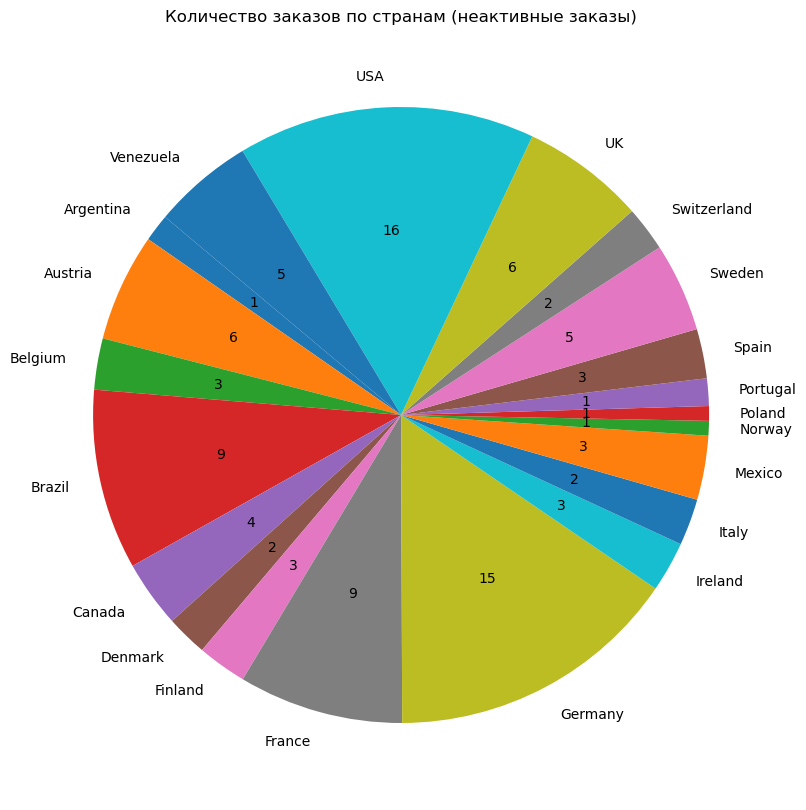

In [96]:
# Создаем PieChart
plt.figure(figsize=(10, 10))
plt.pie(not_active_orders_count_by_country_final, labels=not_active_orders_count_by_country_final.index, autopct='%1.0f', startangle=140)
plt.title('Количество заказов по странам (неактивные заказы)')
plt.show()

Диаграмма отражает распределение ключевых показателей по странам, где **США** и **Германия** лидируют, занимая самые крупные сегменты. Это подчеркивает их высокий вклад в анализируемый показатель и ключевую роль на рынке. **Бразилия** и **Франция** демонстрируют стабильные результаты, занимая средние позиции, что указывает на их важность, но с меньшим влиянием по сравнению с лидерами. 

Страны, такие как **Великобритания**, **Канада**, **Швеция** и **Ирландия**, занимают умеренные доли, что указывает на их значимость, но без доминирующего вклада. 

Меньшие сегменты у **Швейцарии**, **Мексики**, **Испании** и **Италии** указывают на ограниченный вклад этих стран в анализируемый показатель. **Польша**, **Норвегия** и **Португалия** занимают самые малые доли, что делает их менее значимыми в текущем распределении и требует дополнительного анализа для понимания их потенциала. 

Общая картина подчеркивает доминирование **США** и **Германии**, в то время как другие страны занимают разнообразные роли в зависимости от их сегмента.


### Нарисуем круговые диаграммы по выручке и странам. (При этом учитываем неактивные заказы)

In [38]:
cursor.execute("""
select (o.ship_country), ROUND(SUM(od.quantity * od.unit_price)) AS total_revenue

from orders o
left join order_details od ON o.order_id = od.order_id
where o.shipped_date IS NULL  -- Для фильтрации только неактивных заказов
group by o.ship_country, o.order_date, o.shipped_date

order by total_revenue desc;

""")

In [39]:
countries_all_orders_revenue = cursor.fetchall()


In [40]:
countries_all_orders_revenue_pd = pd.DataFrame(countries_all_orders_revenue,
                                               columns=['ship_country', 'total_revenue'])

countries_all_orders_revenue_pd['total_revenue'] = countries_all_orders_revenue_pd['total_revenue'].astype(int)

# Группировка по странам и подсчет суммарной выручки
countries_all_orders_revenue_pd = countries_all_orders_revenue_pd.groupby('ship_country', as_index=False).agg({'total_revenue': 'sum'})

# Сортировка по столбцу 'total_revenue' по убыванию для таблицы
countries_all_orders_revenue_pd = countries_all_orders_revenue_pd.sort_values(by='total_revenue', ascending=False)
countries_all_orders_revenue_pd

,ship_country,total_revenue
1,Austria,10121
2,Brazil,4223
11,Venezuela,3853
6,Germany,2732
10,USA,2085
3,Canada,1310
5,France,1102
9,Switzerland,586
7,Italy,508
0,Argentina,381


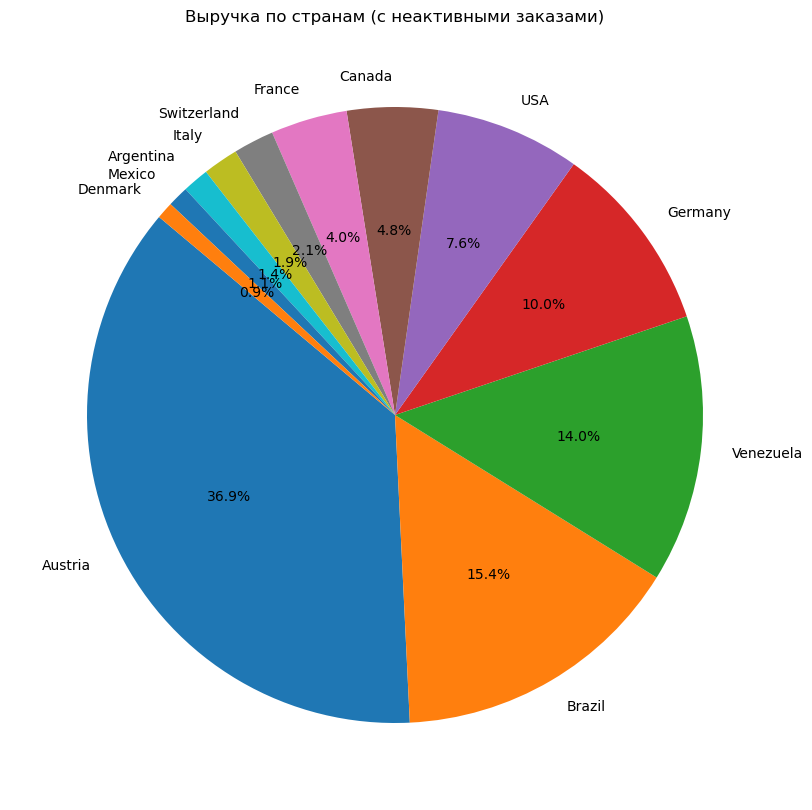

In [41]:
plt.figure(figsize=(10, 10))
plt.pie(countries_all_orders_revenue_pd['total_revenue'], labels=countries_all_orders_revenue_pd['ship_country'], autopct='%1.1f%%', startangle=140)
plt.title('Выручка по странам (с неактивными заказами)')
plt.show()

Диаграмма отражает распределение выручки по странам для неактивных заказов. **Австрия** занимает доминирующее положение, составляя **36.9%** от общей выручки. Это указывает на значительный вклад этой страны в общий объем даже при условии, что заказы остаются неактивными. **Бразилия** находится на втором месте с **15.4%**, демонстрируя также весомый вклад. **США** занимают третье место с долей **7.6%**, что выделяет их среди остальных стран. 

**Германия** и **Франция** занимают значительные позиции с долями **10.0%** и **4.0%** соответственно, подтверждая их важность в общем распределении выручки. Страны с меньшими долями, такие как **Швейцария**, **Мексика** и **Италия**, демонстрируют минимальный вклад в общий объем, составляя около **1-2%** каждая. Наименьшие доли отмечены у **Аргентины** и **Дании**, с долями **1.4%** и **0.9%** соответственно.

Распределение выручки показывает важность крупных рынков, таких как **Австрия**, **Бразилия** и **США**, а также подчеркивает необходимость дополнительного анализа стран с меньшими долями, чтобы понять причины низкого вклада неактивных заказов. Общая структура указывает на значительную диспропорцию в распределении выручки между странами.```

### Нарисуем круговые диаграммы по количеству заказов и странам (При этом учитываем активные заказы)

In [44]:
cursor.execute("""
select
    o.order_id, pr.product_name, pr.product_id, o.customer_id,
    o.employee_id, o.order_date, o.shipped_date, o.ship_city,
    o.ship_country, od.quantity
from orders o
left join order_details od on o.order_id = od.order_id
left join products pr on od.product_id = pr.product_id""")

In [45]:
active_orders_by_country = cursor.fetchall()

In [46]:
active_orders_by_country_pd = pd.DataFrame(active_orders_by_country,
                       columns=['order_id', 'product_name', 'product_id', 'customer_id', 'employee_id', 'order_date', 'shipped_date', 'ship_city', 'ship_country', 'quantity'])
active_orders_by_country_pd['order_act_flag'] = active_orders_by_country_pd.apply(date_mark, axis=1)

active_orders_by_country_pd = active_orders_by_country_pd[active_orders_by_country_pd['order_act_flag'] == 1]

active_orders_by_country_pd_final = not_active_orders_count_by_country.groupby('ship_country')['order_date'].count()

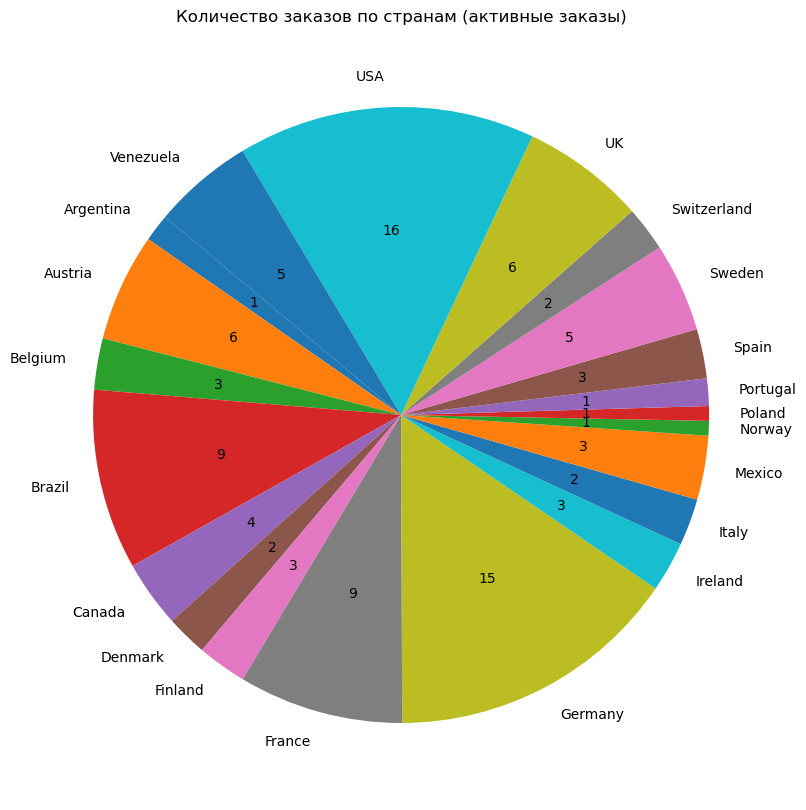

In [47]:
plt.figure(figsize=(10, 10))
plt.pie(active_orders_by_country_pd_final, labels=active_orders_by_country_pd_final.index, autopct='%1.0f', startangle=140)
plt.title('Количество заказов по странам (активные заказы)')
plt.show()

Диаграмма показывает распределение количества активных заказов по странам. **США** и **Германия** занимают лидирующие позиции, имея наибольшее количество активных заказов, что указывает на высокую активность клиентов в этих регионах. **Франция**, **Бразилия** и **Канада** находятся в средней группе, показывая стабильный уровень активности, но уступая лидерам. Страны с минимальными долями, такие как **Италия**, **Швейцария** и **Дания**, имеют меньшее количество активных заказов, что может свидетельствовать о необходимости дополнительного анализа для выявления факторов, ограничивающих активность.

Этот анализ подчеркивает важность крупных рынков, таких как **США** и **Германия**, для основной выручки компании, а также возможности для стимулирования активности на менее активных рынках. Визуализация позволяет быстро определить ключевые рынки и оценить их текущий вклад в объем активных заказов.```


### 9. Нарисуем круговые диаграммы по выручке и странам. (При этом учитываем активные заказы)

In [50]:
cursor.execute("""
select o.ship_country, ROUND(SUM(od.quantity * od.unit_price)) AS total_revenue, o.shipped_date

from orders o
left join order_details od ON o.order_id = od.order_id
group by o.ship_country, o.shipped_date

order by total_revenue desc;

""")

In [51]:
countries_revenue_active_orders = cursor.fetchall()

In [52]:
countries_revenue_active_orders_pd = pd.DataFrame(countries_revenue_active_orders,
                       columns=['ship_country', 'total_revenue', 'shipped_date'])
countries_revenue_active_orders_pd['total_revenue'] = countries_revenue_active_orders_pd['total_revenue'].astype(int)
countries_revenue_active_orders_pd['order_act_flag'] = countries_revenue_active_orders_pd.apply(date_mark, axis=1)

countries_revenue_active_orders_pd_final = countries_revenue_active_orders_pd[countries_revenue_active_orders_pd['order_act_flag'] == 1]

In [53]:
countries_revenue_active_orders_pd_final_final = countries_revenue_active_orders_pd_final.drop(columns=['shipped_date', 'order_act_flag'])

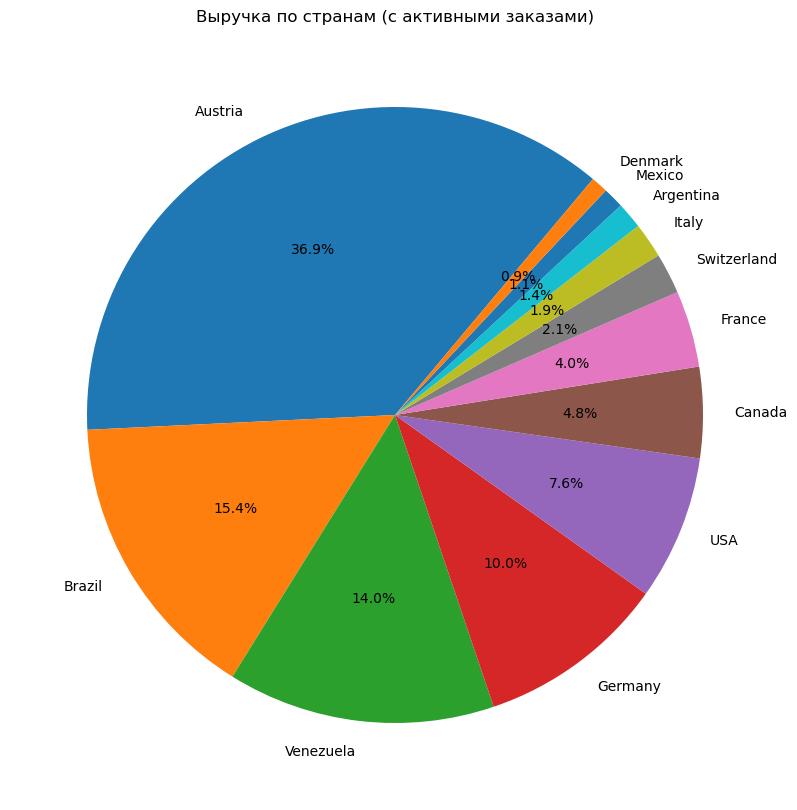

In [54]:
plt.figure(figsize=(10, 10))
plt.pie(countries_revenue_active_orders_pd_final_final['total_revenue'], labels=countries_revenue_active_orders_pd_final_final['ship_country'], autopct='%1.1f%%', startangle=50)
plt.title('Выручка по странам (с активными заказами)')
plt.show()

Диаграмма показывает, что **Австрия** лидирует с долей **36.9%** выручки от активных заказов, за ней следуют **Бразилия** (**15.4%**) и **Венесуэла** (**14.0%**). **Германия** и **США** вносят **10.0%** и **7.6%** соответственно, подтверждая их значимость. Остальные страны, включая **Канаду**, **Францию**, **Швейцарию**, имеют минимальные доли, что указывает на необходимость анализа для увеличения их вклада. Основной фокус стоит направить на лидеров, таких как **Австрия** и **Бразилия**, для максимизации выручки.```


### Выводы и рекомендации в какой стране более выгодно оперировать.

На основе анализа всех предоставленных данных можно сделать вывод, что **Австрия**, **Германия** и **США** являются ключевыми странами для операций благодаря их высокой выручке и количеству активных заказов. **Австрия** показала себя как лидер по общей выручке, особенно среди активных заказов, занимая долю более **36%**, что делает ее наиболее выгодным рынком. **Германия** и **США** выделяются как лидеры по числу заказов, что указывает на высокий уровень клиентской активности.

**Бразилия** и **Венесуэла** также занимают значительные доли по выручке и показывают стабильные результаты, что делает их перспективными для дальнейшего развития. Страны с меньшими долями, такие как **Канада**, **Франция**, **Швейцария**, а также рынки с минимальным вкладом, включая **Польшу** и **Норвегию**, требуют дополнительного анализа. Возможно, в них есть потенциал роста, который можно раскрыть с помощью локализованных стратегий.

Общий вывод: наиболее выгодно сосредоточить усилия на рынках **Австрии**, **Германии**, **США**, а также активно развивать присутствие в **Бразилии** и **Венесуэле**. Для менее активных рынков требуется глубокий анализ и выработка стратегий стимулирования покупательской активности.```
